In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    classification_report, confusion_matrix, precision_recall_curve
)

RANDOM_STATE = 42

In [2]:
# 1. Load Saved Data & Preprocessor

X_train, X_test, y_train, y_test, preprocessor = joblib.load("data_preprocessor.pkl")

In [3]:
# 2. Encode Train/Val/Test 

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

In [4]:
# Fit preprocessor on training split
preprocessor.fit(X_tr)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [5]:
# Transform splits → numeric arrays
X_tr_enc = preprocessor.transform(X_tr)
X_val_enc = preprocessor.transform(X_val)
X_test_enc = preprocessor.transform(X_test)

In [6]:
# 3. Apply SMOTE on encoded train

sm = SMOTE(random_state=RANDOM_STATE)
X_tr_res, y_tr_res = sm.fit_resample(X_tr_enc, y_tr)

In [7]:
# 4. Helper: Train & Evaluate with Threshold

def evaluate_with_threshold(model, name):
    """
    Fit model, tune threshold on validation, evaluate on test.
    """
    model.fit(X_tr_res, y_tr_res)

    # Threshold tuning
    val_proba = model.predict_proba(X_val_enc)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, val_proba)
    f1s = (2 * precisions * recalls) / (precisions + recalls + 1e-9)
    best_idx = np.argmax(f1s[:-1])
    best_thr = float(thresholds[best_idx])

    # Evaluate on test 
    test_proba = model.predict_proba(X_test_enc)[:, 1]
    y_pred = (test_proba >= best_thr).astype(int)

    acc   = accuracy_score(y_test, y_pred)
    bal   = balanced_accuracy_score(y_test, y_pred)
    prec  = precision_score(y_test, y_pred, zero_division=0)
    rec   = recall_score(y_test, y_pred, zero_division=0)
    f1    = f1_score(y_test, y_pred, zero_division=0)
    roc   = roc_auc_score(y_test, test_proba)
    prauc = average_precision_score(y_test, test_proba)

    print(f"\n=== {name} ===")
    print(f"Tuned threshold (on validation): {best_thr:.3f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return {
        "Model": name,
        "Threshold": best_thr,
        "Accuracy": acc,
        "Balanced_Acc": bal,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc,
        "PR_AUC": prauc,
        "Estimator": model
    }

In [8]:
# 5. Train Multiple Models

results = []

#Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
results.append(evaluate_with_threshold(log_reg, "Logistic Regression"))


#Random Forest Classifier
rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
results.append(evaluate_with_threshold(rf, "Random Forest"))

#Gradiant Boosting Classifier
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
results.append(evaluate_with_threshold(gb, "Gradient Boosting"))

# XGBoost
xgb = XGBClassifier(
    n_estimators=300, learning_rate=0.1, max_depth=4,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="logloss", random_state=RANDOM_STATE
)
results.append(evaluate_with_threshold(xgb, "XGBoost"))


=== Logistic Regression ===
Tuned threshold (on validation): 0.456
              precision    recall  f1-score   support

           0       0.90      0.08      0.15     17762
           1       0.10      0.92      0.18      1976

    accuracy                           0.17     19738
   macro avg       0.50      0.50      0.17     19738
weighted avg       0.82      0.17      0.15     19738

Confusion Matrix:
 [[ 1450 16312]
 [  160  1816]]

=== Random Forest ===
Tuned threshold (on validation): 0.027
              precision    recall  f1-score   support

           0       0.75      0.00      0.00     17762
           1       0.10      1.00      0.18      1976

    accuracy                           0.10     19738
   macro avg       0.43      0.50      0.09     19738
weighted avg       0.68      0.10      0.02     19738

Confusion Matrix:
 [[    3 17759]
 [    1  1975]]

=== Gradient Boosting ===
Tuned threshold (on validation): 0.126
              precision    recall  f1-score   supp

In [9]:
# 6. Compare & Pick Best

results_df = pd.DataFrame(results).set_index("Model")
print("\n=== Model Comparison ===\n", results_df[[
    "Accuracy","Balanced_Acc","Precision","Recall","F1","ROC_AUC","PR_AUC","Threshold"
]])


=== Model Comparison ===
                      Accuracy  Balanced_Acc  Precision    Recall        F1  \
Model                                                                        
Logistic Regression  0.165468      0.500332   0.100177  0.919028  0.180661   
Random Forest        0.100213      0.499831   0.100081  0.999494  0.181944   
Gradient Boosting    0.106900      0.501748   0.100429  0.995445  0.182451   
XGBoost              0.195055      0.501254   0.100368  0.884109  0.180270   

                      ROC_AUC    PR_AUC  Threshold  
Model                                               
Logistic Regression  0.503832  0.100051   0.455614  
Random Forest        0.511010  0.105884   0.026667  
Gradient Boosting    0.502791  0.103025   0.126014  
XGBoost              0.509058  0.102005   0.080152  


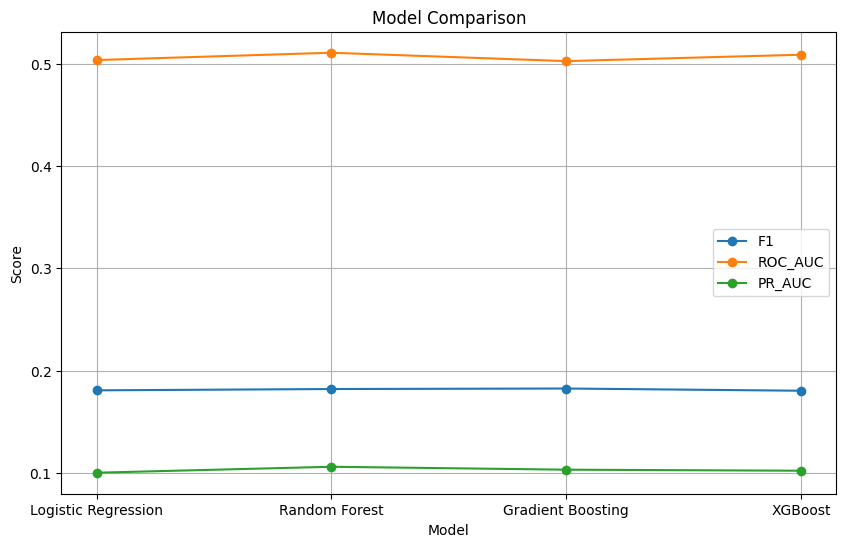

In [10]:
# Plot comparison
plt.figure(figsize=(10,6))
for metric in ["F1", "ROC_AUC", "PR_AUC"]:
    plt.plot(results_df.index, results_df[metric], marker="o", label=metric)
plt.title("Model Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Pick best by PR-AUC
best_by_prauc = results_df["PR_AUC"].idxmax()
print(f"\nBest model by PR-AUC: {best_by_prauc}")

best_model = [r["Estimator"] for r in results if r["Model"] == best_by_prauc][0]



Best model by PR-AUC: Random Forest


In [12]:
# 7. Wrap Final Pipeline

from sklearn.pipeline import Pipeline

final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_model)
])


In [13]:
# Refit full pipeline on complete training data
X_train_enc = preprocessor.fit_transform(X_train)
X_train_res, y_train_res = sm.fit_resample(X_train_enc, y_train)
best_model.fit(X_train_res, y_train_res)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
# Save pipeline
joblib.dump(final_pipeline, "final_model_compressed.pkl", compress=9)
joblib.dump(final_pipeline, "final_model.pkl")
print(f"Saved {best_by_prauc} pipeline as final_model.pkl")

Saved Random Forest pipeline as final_model.pkl
